In [1]:
import sys
sys.path.extend(['fvrmd'])

import imp
import numpy as np
from numpy.random import default_rng
from scipy import signal
from scipy.fft import rfft, rfftfreq
import openseespy.opensees as ops
import pandas as pd

from fvrmd import *

import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML

## 0. Preparation

> Set plotting theme

In [2]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'times new roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['xtick.labelsize'] = 8.5
plt.rcParams['ytick.labelsize'] = 8.5
plt.rcParams['xtick.major.pad'] = 2.1
plt.rcParams['ytick.major.pad'] = 2.1
plt.rcParams['xtick.minor.pad'] = 2.0
plt.rcParams['ytick.minor.pad'] = 2.0
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['axes.labelpad'] = 3
plt.rcParams['axes.titlepad'] = 4.5
plt.rcParams['grid.linewidth'] = .3
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.facecolor'] = '#fefefe'
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = .75
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['ytick.major.width'] = .75
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['figure.subplot.bottom'] = 0.165
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 120


> Define some functions

In [3]:
# plot spectrum of a signal
def plot_spectrum(figsize, data, fs, sensor_locs):
    fig, ax = plt.subplots(figsize=figsize)
    n = data.shape[0]
    Yf = rfft(data, axis=0) * 2 / n
    xf = rfftfreq(n, 1/fs)
    ax.semilogy(xf, np.abs(Yf), '.-', markersize=2)
    ax.legend([f'Node: {i}' for i in sensor_locs])
    ax.set_ylabel('Spectrum of node acc.')
    ax.set_xlabel('Frequency/Hz')
    plt.show()
    return fig, ax

## 1. Artificial damped signal

> Generate a signal with 3 harmonic components

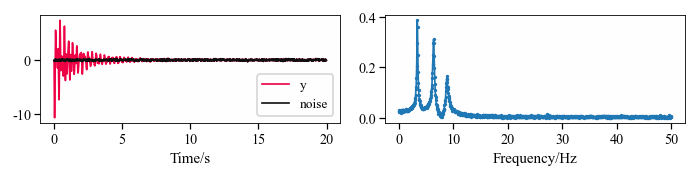

SNR is 19.719534983310677
   Damping factor  Damping ratio  Amplitude  Frequency   Phase
0        0.429443           0.02     3.2399     3.4174  2.5135
1        0.804951           0.02     4.9303     6.4056  1.1902
2        1.110025           0.02     3.5169     8.8333  1.3343


In [4]:
K = 3
fs = 100
T = 20
sig = get_damped_signal(K, T, fs, bound=(
    (2, 5), (0.02, 0.02), (1, 10), (0, 3.14)), 
                        noise_std=0.1, seed=143)
fig = plot_damped_signal((15/2.54, 4/2.54), sig)
fig.savefig('./figures/damped_signal.svg')
print(f'SNR is {snr(sig["y"], sig["noise"])}')
print(pd.DataFrame({
    "Damping factor": sig['damp_r']*sig['freq']*2*np.pi,
    "Damping ratio" : sig['damp_r'],
    "Amplitude": sig['amp'],
    "Frequency": sig['freq'],
    "Phase": sig['phase']
}))

> Use `ERA`, `VMD` and `FVRMD` to identify the parameters

In [5]:
# ERA
N = 1000
y = sig['y'][:N]
resE = ERA(y.reshape(-1, 1), nin=1, order=K, fs=fs)
print(pd.DataFrame({
    "Damping ratio": resE['damp_r'],
    "Error_d (%)": err_in_percent(sig['damp_r'], resE['damp_r']),
    "freqency": resE['freq'],
    "Error_f (%)": err_in_percent(sig['freq'], resE['freq']),
}))

   Damping ratio  Error_d (%)  freqency  Error_f (%)
0       0.019932    -0.339816  3.417424     0.000702
1       0.020025     0.122507  6.405549    -0.000795
2       0.019738    -1.309362  8.834243     0.010677


In [6]:
# VMD
%matplotlib auto
N= 500
resV = VMD(y[:N], fs=fs, alpha=2000, tau=0, K=K, DC=0, init=10, 
           freq0=resE['freq']/fs, tol=1e-8, fix_freq=True)

nf = len(resV['freq'])
fig, ax = plt.subplots(figsize=(15/2.54, 3/2.54), tight_layout=True)
ax.plot(rfftfreq(N, 1/100), np.abs(resV['Y_hat']))
ax.plot(np.array([resV['freq'], resV['freq']]), 
        np.array([np.zeros(nf), np.max(np.abs(resV['Y_hat']))*np.ones(nf)]))
plt.show()

fig, axes = plt.subplots(K, 1, figsize=(15/2.54, 6/2.54), 
                         sharex=True, tight_layout=True)
for k in range(K):
    axes[k].plot(resV['Y'][:, k], lw=0.7, label='VMD')
    axes[k].plot(sig['Y'][:, k], '--', lw=0.7, label='True')
    axes[k].legend()
plt.show()

print(pd.DataFrame({
    "amplitude": resV['amp'],
    "Err_a": err_in_percent(sig['amp'], resV['amp']),
    "damping_ratio": resV['damp_r'],
    "Err_d": err_in_percent(sig['damp_r'], resV['damp_r']),
    "freqency": resV['freq'],
    "Err_f": err_in_percent(sig['freq'], resV['freq']),
    "freqency2": resV['freq2'],
    "Err_f2": err_in_percent(sig['freq'], resV['freq2']),
    "phase": resV['phase'],
    "Err_p": err_in_percent(sig['phase'], resV['phase'])
}))


Using matplotlib backend: <object object at 0x000001C2A903C340>
   amplitude      Err_a  damping_ratio      Err_d  freqency     Err_f  \
0   3.235746  -0.128208       0.019723  -1.386352  3.417424  0.000702   
1   5.032963   2.082296       0.020171   0.856873  6.405549 -0.000795   
2   4.892138  39.103690       0.022589  12.944206  8.834243  0.010677   

   freqency2    Err_f2     phase      Err_p  
0   3.417700  0.008764  2.522149   0.344096  
1   6.403724 -0.029286  1.216310   2.193770  
2   8.821087 -0.138257  1.533262  14.911328  


In [7]:
# FVRMD
freq, sigma = resE['freq'], np.zeros(K)
a0 = 1/freq * fs * 10
a = - 1/freq * fs * (np.log(0.5) / (0.02*(2*np.pi)))
a1 = 1/freq * fs * 30
print(pd.DataFrame({
    'a0': a0,
    "a": a,
    "a1": a1
}))
a[a < a0] = a0[a < a0]
a[a > a1] = a1[a > a1]
# a = 1/freq * fs * 10
# a = np.array([334, 118, 140])
# a = [334, 175, 118]
n_seg = np.array(a, dtype=int)
print(n_seg)
resF, logF = FVRMD(sig['y'][:1000], fs, sigma, freq, n_seg, alpha=1e2, beta=1,
                 gamma=20, delta_damp_r=0.01, tau=1e-8, r=1, delta_diff=1e-6, 
                 seg=(1/4, 3/4), delta_reg=1e-6, max_iters=200, quite=True)
                 
print(pd.DataFrame({
    "amplitude": resF['amp'],
    "Err_a": err_in_percent(sig['amp'], resF['amp']),
    "damping_ratio": resF['damp_r'],
    "Err_d": err_in_percent(sig['damp_r'], resF['damp_r']),
    "freqency": resF['freq'],
    "Err_f": err_in_percent(sig['freq'], resF['freq']),
    "phase": resF['phase'],
    "Err_p": err_in_percent(sig['phase'], resF['phase']),
}))

           a0           a          a1
0  292.618066  161.404906  877.854197
1  156.114642   86.111119  468.343925
2  113.195889   62.437607  339.587666
[292 156 113]
   amplitude     Err_a  damping_ratio     Err_d  freqency     Err_f     phase  \
0   3.209903 -0.925854       0.019251 -3.743251  3.417559  0.004643  2.518899   
1   4.912436 -0.362321       0.019942 -0.291949  6.404309 -0.020153  1.200548   
2   3.394331 -3.485150       0.018686 -6.567698  8.833916  0.006978  1.329649   

      Err_p  
0  0.214817  
1  0.869417  
2 -0.348563  


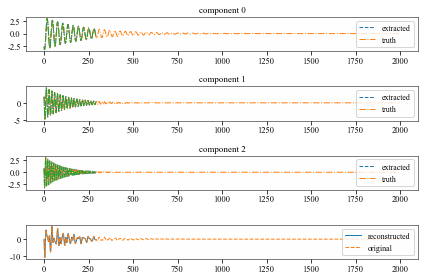

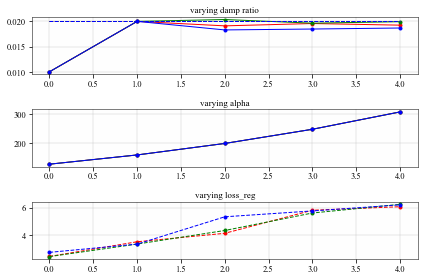

In [8]:
# plt.show()
%matplotlib inline
K = len(resF['freq'])
t = sig['time']
fig, axs = plt.subplots(K+1, 1, tight_layout=True)
for i in range(K):
    axs[i].plot(resF['Y'][:, i], '--', lw=1, label='extracted')
    temp = sig['Y'][:, i]
    axs[i].plot(temp, '-.', lw=1, label='truth')
    axs[i].plot(resF['Y_rec'][:, i], '-.')
    axs[i].legend()
    axs[i].set_title(f'component {i}')
axs[K].plot(np.sum(resF['Y'], axis=1), label='reconstructed')
axs[K].plot(sig['y'] - sig['noise'], '--', label='original')
axs[K].legend()

# damp
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, tight_layout=True)
# lns = ax1.plot(np.log(Log['damp']), marker='.')
lns = ax1.plot(logF['damp_r'], marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = ax1.plot(np.ones_like(logF['damp_r']) * sig['damp_r'], '--')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
# ax1.legend([1, 2, 3, -1, -2, -3])
ax1.grid()
ax1.set_title('varying damp ratio')
lns = ax2.plot((logF['alpha']), marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax2.grid()
ax2.set_title('varying alpha')
lns = ax3.plot(-np.log10(logF['loss_reg']), '--', marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
# ax3.legend([1, 2, 3, -1, -2, -3])
ax3.grid()
ax3.set_title('varying loss_reg')
plt.show()


## FEM-simulated simply supported beam

### Free response excited by impulse force 

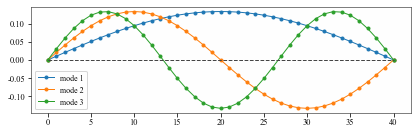

   Theoretical freqency   Freqency  Err. (%)  Damping ratio  Damping factor
0              3.322592   3.322592 -0.000003         0.0200        0.417529
1             13.290368  13.290362 -0.000043         0.0125        1.043824
2             29.903327  29.903262 -0.000217         0.0200        3.757755


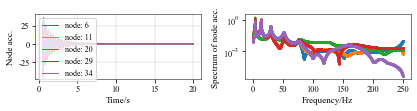

SNR_0 is: 25.26708043104353
SNR_1 is: 27.32940990855043
SNR_2 is: 25.445479893358836
SNR_3 is: 27.542465062745446
SNR_4 is: 25.337583214300643


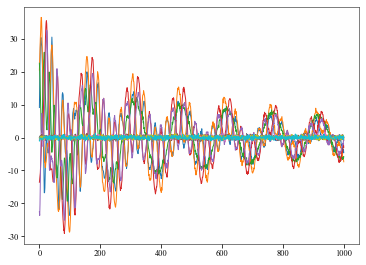

In [7]:
%matplotlib inline
fs = 500
T = 20
analysis_params = {
    "zeta":                 0.02,
    "fs":                   fs,
    "tol_time":             T,
    "num_eig":              3,
    "idx_for_damp_ratio":   [0, 2]
}
# pattern
# 0: burst force; 1: random force on single node
# 2: random force on  5 nodes
load_params = {"pattern": 0, "duration": 0.5, "magnitude": 1000,
               "location": [8], "seed": 111}

sensor_locs = [6, 11, 20, 29, 34]

res0 = get_response_from_simply_supported_beam(
    analysis_params=analysis_params, load_params=load_params)

fig = plot_mode((15/2.54, 5/2.54), res0['mode'])

res_FEM = pd.DataFrame({
    "Theoretical freqency": res0['freq_theory'],
    "Freqency": res0['freq'],
    "Err. (%)": err_in_percent(res0['freq_theory'], res0['freq']),
    "Damping ratio": res0['damp_r'],
    "Damping factor": 2*np.pi*res0['freq']*res0['damp_r']
})
print(res_FEM)
fig = plot_response((15/2.54, 4/2.54), res0['time'], res0['acc'][:, sensor_locs],
              sensor_locs, analysis_params['fs'], t_start=0.51)

a = int(0.6*fs)
N = 1000
num_sensor = len(sensor_locs)
data_clean = res0['acc'][a:a+N, sensor_locs]

noise_std, noise_level = .4, 'low'
# noise_std, noise_level = 4., 'high'

noise = np.zeros_like(data_clean)
data = np.zeros_like(data_clean)
for k in range(num_sensor):
    noise[:, k] = get_noise(N, noise_std, seed=121+k)
    data[:, k] = data_clean[:, k] + noise[:, k]
    print(f'SNR_{k} is: {snr(data[:1000, k], noise[:1000, k])}')
plt.plot(data)
plt.plot(noise)


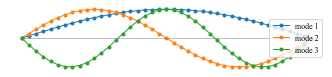

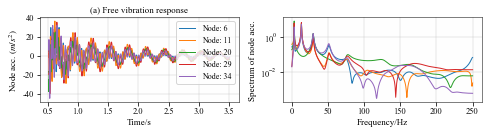

In [10]:
fig, ax = plt.subplots(figsize=(12/2.54, 3/2.54), tight_layout=True)
ax.plot(res0['mode'], marker='.')
ax.plot([0, 40], [0, 0], 'grey', alpha=0.5)
ax.axis('off')
ax.legend(['mode 1', 'mode 2', 'mode 3'], loc='right')
# fig.savefig('./figures/mode_FEM.svg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17.5/2.54, 5/2.54), tight_layout=True)
t_start = 0.51
t_end = 3.51
a = int(t_start*fs)
b = int(t_end*fs)
sig = res0['acc'][a:b, sensor_locs]
time = res0['time'][a:b]
n = len(time)
for j, s in enumerate(sensor_locs):
    ax1.plot(time, sig[:, j], label=f'Node: {s:1d}', lw=1)
ax1.grid('on')
ax1.legend(loc='upper right')
ax1.set_ylabel('Node acc. $(m/s^2)$')
ax1.set_xlabel('Time/s')
ax1.set_title('(a) Free vibration response')

for j, s in enumerate(sensor_locs):
    Yf = rfft(sig[:, j]) * 2 / n
    xf = rfftfreq(n, 1/fs)
    ax2.semilogy(xf, np.abs(Yf), label=f'node: {s:1d}')
ax2.grid('on')
ax2.set_ylabel('Spectrum of node acc.')
ax2.set_xlabel('Frequency/Hz')
plt.show()
# fig.savefig('./figures/FVR_spectrum_FEM.svg')


Parameters identification by `ERA` and `FVRMD`

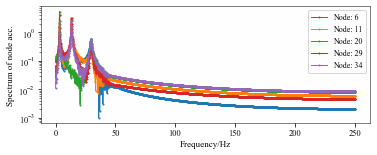

In [11]:
# preprocessing
b, a = signal.butter(N=10, Wn=40, btype='low', output='ba', 
                     fs=analysis_params['fs'])
data_f = signal.filtfilt(b, a, data, axis=0)
fig, ax = plot_spectrum((15/2.54, 5/2.54), data_f, fs, sensor_locs)


Results by `ERA`:
   Damping ratio   Error_d   Freqency  Error_f (%)
0       0.019684 -1.581790   3.321838    -0.022699
1       0.012609  0.875244  13.253642    -0.276290
2       0.021682  8.408850  29.533462    -1.236655
   MAC ERA-FEM
0     0.999843
1     0.999616
2     0.995786


(-2.0, 42.0, -1.1, 1.1)

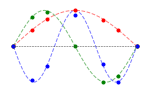

In [4]:
# ERA
K = 3
resE = ERA(data[:2000], nin=1, order=K, fs=fs)
print('Results by `ERA`:')
print(pd.DataFrame({
    "Damping ratio": resE['damp_r'],
    "Error_d": err_in_percent(res0['damp_r'][:K], resE['damp_r']),
    "Freqency": resE['freq'],
    "Error_f (%)": err_in_percent(res0['freq'][:K], resE['freq'])
}))

s_loc = np.concatenate(([0], sensor_locs, [40]))
x_loc = np.arange(41)

mode_t = res0['mode']/np.abs(res0['mode']).max(axis=0) # FEM mode
modeE = resE['mode']/np.abs(resE['mode']).max(axis=0)  # ERA mode
mask = np.sign(mode_t[sensor_locs, :])  # define a mask as the signs of mode
modeE = mask * np.abs(modeE)

# MAC
macE = [get_MAC(mode_t[sensor_locs, k], modeE[:, k]) for k in range(K)]
print(pd.DataFrame({
    'MAC ERA-FEM': macE
}))

# mode shape
modeE = np.concatenate((np.zeros((1, K)),
                       modeE,
                       np.zeros((1, K))), axis=0)

fig, ax = plt.subplots(figsize=(5/2.54, 3/2.54), layout="constrained")
lns = ax.plot(x_loc, mode_t, '--', lw=1, alpha=0.5)
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = plt.plot(s_loc, modeE, '.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax.plot(x_loc, np.zeros(x_loc.shape), '--', c='#454545', lw=0.5)
ax.axis('off')
# fig.savefig(f'./figures/mode_ERA_{noise_level}_n.svg')

In [26]:
# FVRMD
K = 3
ampF = np.zeros((num_sensor, K))
damp_rF = np.zeros((num_sensor, K))
freqF = np.zeros((num_sensor, K))
phaseF = np.zeros((num_sensor, K))
damp_rF_err = np.zeros((num_sensor, K))
freqF_err = np.zeros((num_sensor, K))
order = [[0, 1, 2],
         [0, 1, 2],
         [0, 2],
         [0, 1, 2],
         [0, 1, 2]]  # prior knowledge

for chn in range(num_sensor):
    K = len(order[chn])
    res = ERA(data[:1000, chn].reshape(-1, 1), nin=1, order=K, fs=fs)
    # print(pd.DataFrame({
    #     "Damping ratio": res['damp_r'],
    #     "Error_d": err_in_percent(res0['damp_r'][order[chn]], res['damp_r']),
    #     "Freqency": res['freq'],
    #     "Error_f (%)": err_in_percent(res0['freq'][order[chn]], res['freq'])
    # }))
    
    for i in [0]:
        if i == 0:
            freq0 = 0.95*res0['freq'][order[chn]]
            # a = np.array([1000, 500, 180])
            a = 1/freq0 * fs * 10
            # damp_r0 = 0.015
        elif i == 1:
            freq0 = resF['freq']
            damp_r0 = resF['damp_r']
            
            # a = 1/freq0 * fs * (-np.log(0.25) / (damp_r0*2*np.pi))
            # a_min = (1/freq0) * 5 * fs  # ensure frequency estimation
            # a_max = (1/freq0) * 10 * fs
            # a[a < a_min] = a_min[a < a_min]
            # a[a > a_max] = a_max[a > a_max]
    
        # a = np.sqrt(1/freq0) * fs * (-np.log(0.2) / (damp_r0*2*np.pi))
        n_seg = np.array(a, dtype=int)
        print(n_seg)
        damp_r0 = np.zeros(K)
        dataF = data[:3000, chn]
        resF, logF = FVRMD(dataF, fs, damp_r0, freq0, n_seg, alpha=1e2, beta=0.5,
                        gamma=10, delta_damp_r=0.01, tau=1e-8, r=1, delta_diff=1e-8,
                        seg=(1/4, 3/4), delta_reg=1e-8, max_iters=100, quite=True)

        ampF[chn, order[chn]] = resF['amp']
        damp_rF[chn, order[chn]] = resF['damp_r']
        damp_rF_err[chn, order[chn]] = err_in_percent(res0['damp_r'][order[chn]],
                                                   resF['damp_r'])
        freqF[chn, order[chn]] = resF['freq']
        freqF_err[chn, order[chn]] = err_in_percent(res0['freq'][order[chn]],
                                                   resF['freq'])
        phaseF[chn, order[chn]] = resF['phase']
        # print(f'Results by `FVRMD`(sensor {sensor_locs[chn]}):')
        # print(pd.DataFrame({
        #     "amplitude": resF['amp'],
        #     "damping_ratio": resF['damp_r'],
        #     "Err_d.": err_in_percent(res0['damp_r'][order[chn]], resF['damp_r']),
        #     "freqency": resF['freq'],
        #     "Err_f.": err_in_percent(res0['freq'][order[chn]], resF['freq']),
        #     "phase": resF['phase']
        # }))
        # print('')

[1584  396  176]
[1584  396  176]
[1584  176]
[1584  396  176]
[1584  396  176]


Results by `FVRMD`:
   Damping ratio  Error_d  Freqency  Error_f (%)
0        0.02040     2.01    3.3194        -0.09
1        0.01323     5.85   13.2410        -0.37
2        0.02223    11.13   29.6783        -0.75
   MAC ERA-FEM
0     0.999917
1     0.999450
2     0.993218


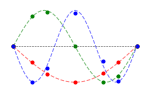

In [33]:
resF = params_assemble(ampF, damp_rF, freqF, phaseF, ref=0, method='max')

print('Results by `FVRMD`:')
vv = np.array(resF['damp_r'])
ww = np.array(resF['freq'])
print(pd.DataFrame({
    "Damping ratio": np.round(vv*1e5)/1e5,
    "Error_d": np.round(err_in_percent(res0['damp_r'][:K], resF['damp_r'])*1e2)/1e2,
    "Freqency": np.round(ww*1e4)/1e4,
    "Error_f (%)": np.round(err_in_percent(res0['freq'][:K], resF['freq'])*1e2)/1e2
}))

s_loc = np.concatenate(([0], sensor_locs, [40]))
x_loc = np.arange(41)

mode_t = res0['mode']/np.abs(res0['mode']).max(axis=0)  # FEM mode
mode_t[:, 0] = -mode_t[:, 0]
mode_t[:, 2] = -mode_t[:, 2]
modeE = resF['mode']/np.abs(resF['mode']).max(axis=0)  # ERA mode
mask = np.sign(mode_t[sensor_locs, :])  # define a mask as the signs of mode
modeE = mask * np.abs(modeE)

# MAC
macE = [get_MAC(mode_t[sensor_locs, k], modeE[:, k]) for k in range(K)]
print(pd.DataFrame({
    'MAC ERA-FEM': macE
}))

# mode shape
modeE = np.concatenate((np.zeros((1, K)),
                       modeE,
                       np.zeros((1, K))), axis=0)

fig, ax = plt.subplots(figsize=(5/2.54, 3/2.54), layout="constrained")
lns = ax.plot(x_loc, mode_t, '--', lw=1, alpha=0.5)
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = plt.plot(s_loc, modeE, '.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax.plot(x_loc, np.zeros(x_loc.shape), '--', c='#454545', lw=0.5)
ax.axis('off')
fig.savefig(f'./figures/mode_FVRMD_{noise_level}_n.svg')


In [107]:
print('Amplitude:')
print(pd.DataFrame(ampF))
print('Damping ratio:')
print(pd.DataFrame(damp_rF))
print(pd.DataFrame(damp_rF_err))
print('Frequency')
print(pd.DataFrame(freqF))
print(pd.DataFrame(freqF_err))
print('Phase')
print(pd.DataFrame(phaseF))

Amplitude:
           0          1          2
0   6.608758  18.599889  13.166610
1  11.395666  21.351112   7.788030
2  14.918682   0.000000  12.104270
3  11.268734  22.167333   5.188806
4   6.632254  18.192189  12.578245
Damping ratio:
          0         1         2
0  0.017401  0.013732  0.023327
1  0.020101  0.012763  0.026495
2  0.020424  0.000000  0.021132
3  0.021600  0.013215  0.006083
4  0.018913  0.013101  0.018693
           0         1          2
0 -12.995142  9.854308  16.636709
1   0.505469  2.103374  32.472690
2   2.119605  0.000000   5.659768
3   7.998557  5.721443 -69.583578
4  -5.437390  4.807011  -6.535915
Frequency
          0          1          2
0  3.304973  13.226947  29.698333
1  3.320810  13.245885  29.652982
2  3.318875   0.000000  29.530093
3  3.319096  13.240339  29.537276
4  3.320587  13.254011  29.377838
          0         1         2
0 -0.530262 -0.477151 -0.685308
1 -0.053624 -0.334655 -0.836968
2 -0.111866  0.000000 -1.247921
3 -0.105212 -0.376382 -1.2

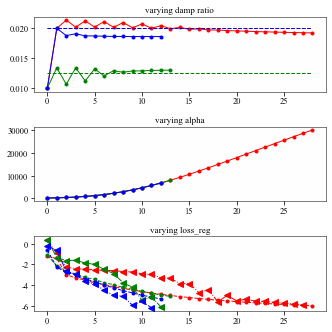

In [31]:
# fig, ax = plt.subplots(figsize=(12/2.54, 4/2.54))
# lns = ax.plot(resF['Y'])
# [lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
# ax.set_xlim(0, n_seg[0])
# ax.set_title('Estimated components')

# fig, ax = plt.subplots(figsize=(12/2.54, 5/2.54))
# ax.plot(data_clean[:n_seg[0], chn], label='Clean signal')
# ax.plot(resF['Y'].sum(axis=1), '--', label='Reconstructed signal')
# ax.set_xlim(0, n_seg[0])
# ax.legend()

# damp
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(12/2.54, 12/2.54), tight_layout=True)
lns = ax1.plot(logF['damp_r'], marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = ax1.plot(np.ones_like(logF['damp_r']) * res0['damp_r'], '--')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax1.set_title('varying damp ratio')
lns = ax2.plot((logF['alpha']), marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax2.set_title('varying alpha')
lns = ax3.plot(np.log10(logF['loss_reg']), '--', marker='.')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
lns = ax3.plot(np.log10(logF['diff'][1:]), '-.', marker='<')
[lns[i].set_color(c) for i, c in enumerate(('r', 'g', 'b'))]
ax3.set_title('varying loss_reg')
plt.show()


### Random response excited by random forces (simulate ambient excitation)

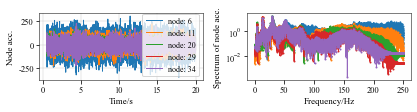

494 trigger points found.
811 trigger points found.
952 trigger points found.
1170 trigger points found.
833 trigger points found.


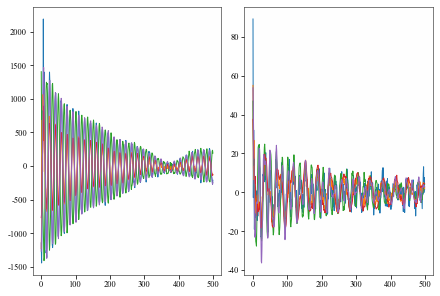

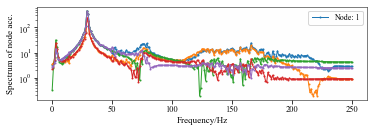

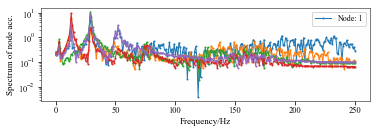

(<Figure size 425.197x113.386 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency/Hz', ylabel='Spectrum of node acc.'>)

In [156]:
fs = 500
T = 20
analysis_params = {
    "zeta":                 0.02,
    "fs":                   fs,
    "tol_time":             T,
    "num_eig":              3,
    "idx_for_damp_ratio":   [0, 2]
}
# pattern
# 0: burst force; 1: random force on single node
# 2: random force on  5 nodes
load_params = {"pattern": 2, "duration": 0.5, "magnitude": 1000,
               "location": [8], "seed": 121}

sensor_locs = [6, 11, 20, 29, 34]

res0 = get_response_from_simply_supported_beam(
    analysis_params=analysis_params, load_params=load_params)

fig = plot_response((15/2.54, 4/2.54), res0['time'], res0['acc'][:, sensor_locs],
                    sensor_locs, analysis_params['fs'], t_start=0.51)

num_sensor = len(sensor_locs)
data = res0['acc'][:, sensor_locs]

# noise_std, noise_level = .4, 'low'
# noise_std, noise_level = 4., 'high'

# noise = np.zeros_like(data_clean)
# data = np.zeros_like(data_clean)
# for k in range(num_sensor):
#     noise[:, k] = get_noise(N, noise_std, seed=121+k)
#     data[:, k] = data_clean[:, k] + noise[:, k]
#     print(f'SNR_{k} is: {snr(data[:1000, k], noise[:1000, k])}')
# plt.plot(data)
# plt.plot(noise)
%matplotlib inline
y_next = NeXT(data, fs, [2], 500)
seg_len = 500
y_rdt = np.zeros((seg_len, data.shape[1]))
for i in range(data.shape[1]):
    trigger = 1 * np.std(data[:, i])
    y_rdt[:, i], _ = RDT(data[:, i], fs, y_trigger=trigger, n_segment=seg_len)
fig, ax = plt.subplots(1, 2, layout="constrained")
ax[0].plot(y_next[0])
ax[1].plot(y_rdt)
plot_spectrum((15/2.54, 4/2.54), y_next[0], fs, [1])
plot_spectrum((15/2.54, 4/2.54), y_rdt, fs, [1])


Results by `ERA`:
   Damping ratio     Error_d   Freqency  Error_f (%)
0       0.013103    4.825444  29.404241   121.244847
1      -0.009177 -145.883034  29.695579    -0.694517
   MAC ERA-FEM
0     0.607387
1     0.999138


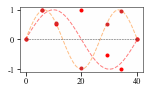

In [166]:
order = [1, 2]
K = len(order)
resE = ERA(y_next[0], nin=1, order=K, fs=fs)
print('Results by `ERA`:')
print(pd.DataFrame({
    "Damping ratio": resE['damp_r'],
    "Error_d": err_in_percent(res0['damp_r'][order], resE['damp_r']),
    "Freqency": resE['freq'],
    "Error_f (%)": err_in_percent(res0['freq'][order], resE['freq'])
}))

s_loc = np.concatenate(([0], sensor_locs, [40]))
x_loc = np.arange(41)

mode_t = res0['mode'][:, order]/np.abs(res0['mode'][:, order]).max(axis=0)  # FEM mode
modeE = resE['mode']/np.abs(resE['mode']).max(axis=0)  # ERA mode
mask = np.sign(mode_t[sensor_locs, :])  # define a mask as the signs of mode
modeE = mask * np.abs(modeE)

# MAC
macE = [get_MAC(mode_t[sensor_locs, k], modeE[:, k]) for k in range(K)]
print(pd.DataFrame({
    'MAC ERA-FEM': macE
}))

# mode shape
modeE = np.concatenate((np.zeros((1, K)),
                       modeE,
                       np.zeros((1, K))), axis=0)

fig, ax = plt.subplots(figsize=(5/2.54, 3/2.54), layout="constrained")
lns = ax.plot(x_loc, mode_t, '--', lw=1, alpha=0.5)
[lns[i].set_color(c) for i, c in enumerate(('r'))]
lns = plt.plot(s_loc, modeE, '.')
[lns[i].set_color(c) for i, c in enumerate(('r'))]
ax.plot(x_loc, np.zeros(x_loc.shape), '--', c='#454545', lw=0.5)


In [163]:
K = 3
ampF = np.zeros((num_sensor, K))
damp_rF = np.zeros((num_sensor, K))
freqF = np.zeros((num_sensor, K))
phaseF = np.zeros((num_sensor, K))
damp_rF_err = np.zeros((num_sensor, K))
freqF_err = np.zeros((num_sensor, K))
order = [[1, 2],
         [1, 2],
         [2],
         [1, 2],
         [1, 2]]  # prior knowledge

for chn in range(num_sensor):
    K = len(order[chn])   
    freq0 = 0.95*res0['freq'][order[chn]]
    a = 1/freq0 * fs * 10
    n_seg = np.array(a, dtype=int)
    n_seg[n_seg > data.shape[0]] = data.shape[0]
    print(n_seg)
    damp_r0 = np.zeros(K)
    dataF = y_next[0][:, chn]
    resF, logF = FVRMD(dataF, fs, damp_r0, freq0, n_seg, alpha=1e2, beta=1,
                    gamma=10, delta_damp_r=0.01, tau=1e-2, r=1, delta_diff=1e-6,
                    seg=(1/4, 3/4), delta_reg=1e-6, max_iters=100, quite=True)

    ampF[chn, order[chn]] = resF['amp']
    damp_rF[chn, order[chn]] = resF['damp_r']
    damp_rF_err[chn, order[chn]] = err_in_percent(res0['damp_r'][order[chn]],
                                                resF['damp_r'])
    freqF[chn, order[chn]] = resF['freq']
    freqF_err[chn, order[chn]] = err_in_percent(res0['freq'][order[chn]],
                                                resF['freq'])
    phaseF[chn, order[chn]] = resF['phase']

[396 176]
[396 176]
[176]
[396 176]
[396 176]


Results by `FVRMD`:
   Damping ratio     Error_d   Freqency  Error_f (%)
0       0.000000 -100.000000   0.000000  -100.000000
1       0.011383   -8.934375  29.764539   123.955822
2       0.010194  -49.030469  29.757070    -0.488885
   MAC ERA-FEM
0     0.566659
1     0.450974


d:\1-Projects\FVRMD\fvrmd\utils\utils.py:76: RuntimeWarning: invalid value encountered in divide
  mode = amp / amp.max(axis=0) * sign


(-2.0, 42.0, -1.1, 1.1)

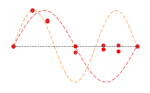

In [165]:
K = 3
resF = params_assemble(ampF, damp_rF, freqF, phaseF, ref=0, method='max')
order = [1, 2]
print('Results by `FVRMD`:')
print(pd.DataFrame({
    "Damping ratio": resF['damp_r'],
    "Error_d": err_in_percent(res0['damp_r'][:K], resF['damp_r']),
    "Freqency": resF['freq'],
    "Error_f (%)": err_in_percent(res0['freq'][:K], resF['freq'])
}))

s_loc = np.concatenate(([0], sensor_locs, [40]))
x_loc = np.arange(41)

mode_t = res0['mode'][:, order]/np.abs(res0['mode'][:, order]).max(axis=0)  # FEM mode
modeE = resF['mode'][:, order]/np.abs(resF['mode'][:, order]).max(axis=0)  # ERA mode
mask = np.sign(mode_t[sensor_locs, :])  # define a mask as the signs of mode
modeE = mask * np.abs(modeE)

# MAC
K = len(order)
macE = [get_MAC(mode_t[sensor_locs, k], modeE[:, k]) for k in range(K)]
print(pd.DataFrame({
    'MAC ERA-FEM': macE
}))

# mode shape
modeE = np.concatenate((np.zeros((1, K)),
                       modeE,
                       np.zeros((1, K))), axis=0)

fig, ax = plt.subplots(figsize=(5/2.54, 3/2.54), layout="constrained")
lns = ax.plot(x_loc, mode_t, '--', lw=1, alpha=0.5)
[lns[i].set_color(c) for i, c in enumerate(('r'))]
lns = plt.plot(s_loc, modeE, '.')
[lns[i].set_color(c) for i, c in enumerate(('r'))]
ax.plot(x_loc, np.zeros(x_loc.shape), '--', c='#454545', lw=0.5)
ax.axis('off')

In [ ]:
damp_r0 = res['damp_r']
1/freq0 * fs * (-np.log(0.25) / (damp_r0*2*np.pi))

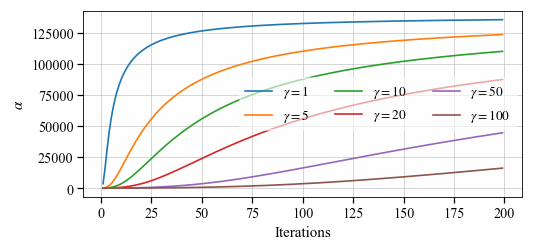

In [5]:
jj = np.arange(1, 200)
gamma = [1, 5, 10, 20, 50, 100]
alpha0 = 100
fig, ax = plt.subplots(figsize=(12/2.54, 5/2.54))
for g in gamma:
    alpha = alpha0 * 10**(2*np.arctan(jj/g))
    ax.plot(jj, alpha)
lgd = ax.legend([f'$\gamma={g}$' for g in gamma], loc='right', ncol=3,
                framealpha=0.6, edgecolor='w')
ax.grid()
ax.set_xlabel('Iterations')
ax.set_ylabel(r'$\alpha$')
fig.savefig('./manuscript/LatexFile/figures/adaptive_alpha.pdf')